# Meta-analysis

Meta-analysis is used to combine evidence from multiple studies, usually clinical trials testing the effectiveness of therapies or tests. The pooled evidence from multiple studies can give much more precise and reliable answers than any single study can. Although many researchers are convinced that meta-analyses are hugely important and helpful, others doubt that meta-analysis can consistently overcome the huge challenges and produce consistently useful results:

- inconsistent criteria to define a disease => define which patients are included
- different outcome variables => define which outcomes are included
- unpublished studies/publication bias => seek unpublished data, review registries of study protocols
- some studies are of higher quality than others => define what makes a study of high enough quality to be included
- different languages => arrange for translation
- not enough information to perform a proper analysis => estimate data from figures, obtain unpublished details from investigators
- published data may be internally inconsistent => resolve inconsistencies without bias, request details from investigators
- data from some patients may be included in multiple publications, redundant analyses => ask investigators to clarify which patients were included in more than one publication

A meta-analysis pools weighted effect sizes, it calculates a pooled P value from the pooled effect size.

Meta-analyses don't have to be huge, it can be helpful to combine the results from as few as two studies.

## Assumptions of meta-analysis

There are two general methods that are used, each of which is based on different assumptions:

- _fixed effects_: this model assumes that all the subjects in all the studies were really sampled from one large population. Thus, all teh studies are estimating the same effect, and the only difference between studies is due to random selection of subjects.
- _random effects_: this model assumes that each study population is unique. The difference among study results is due both to differences between the populations and to random selection of subjects. This model is more realistic and is used more frequently.

In [1]:
# We use the data extracted from Figure 43.1 on page 455
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mean = np.array([2.5, 1.4, 1.1, 1.2,  .8,  .8, 1.1, np.NaN, 1.2])
lower= np.array([1.8,  .8,  .8,  .8,  .5,  .4,  .6, np.NaN,  .9])
upper= np.array([4.4, 2.2, 1.8, 1.9, 1.4, 1.6, 2,   np.NaN, 1.4])
W = (upper-lower)/2

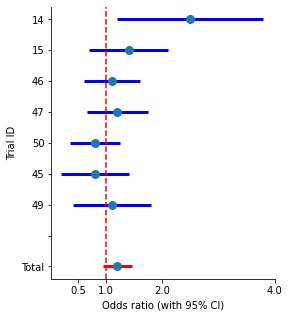

In [26]:
plt.figure(figsize=(4,5))
plt.errorbar(
    x=np.flip(mean),
    y=np.arange(len(mean)),
    xerr=np.flip(W),
    fmt='o',
    ms=8,
    ecolor=['red']+['blue']*8,
    elinewidth=3,
)

plt.xlabel("Odds ratio (with 95% CI)")
plt.xticks([0.5, 1, 2, 4.0])
plt.ylabel("Trial ID")
plt.yticks(
    list(range(0,9)),
    ['Total', '', '49', '45', '50', '47', '46', '15', '14'])
plt.axvline(x=1, color='red', linestyle='--')
sns.despine();

## Results from a meta-analysis

Part of a meta-analysis is a narrative report that summarizes the studies that have been done and evaluates their strengths and weaknesses. The rest of a meta-analysis is quantitative. The results of each study are summarized by one value, called the **effect size**, along with its CI. The effect size is usually a relative risk or odds ratio, but it could also be some other measure of treatment effect. Combining all the studies, the meta-analysis computes the pooled treatment effect, its CI and a pooled P value.

The results for the individual studies and the pooled results are plotted on a **forest plot** or **blobbogram**.

In the example above, the forest plot shows the results from 7 studies of the effectiveness of a drug, the horizontal axis is the odds ratio, a value of 1.0 means no effect; a value greater than 1.0 means the drug works better than placebo. The top 7 lines are results of individual studies. For each study, the plot shows the odds ratio and 95% confidence interval. At the very bottom, the graph shows the total (pooled) effect computed from all studies, also shown as an odds ratio with its 95% CI.

In 6 of the 7 studies, the 95% CI includes 1.0. With 95% confidence, you cannot conclude from these six studies that the treatment works better than placebo. In only 1 of the studies, does the 95% CI not include 1.0. The data from this study, but not the others, would lead you to conclude with 95% confidence that the treatment worked better than placebo. The bottom part of the graph shows the total (pooled) effect as computed by the meta-analysis. The 95% CI ranges from 0.98 to 1.56, so the P value must be greater than 0.05. The overall odds ratio is 1.24. That is a small effect, but not a tiny one. The 95% CI includes 1.0 (no effect), but just barely.

## Implementation in Python

Statsmodels include basic methods for [meta-analysis](https://www.statsmodels.org/stable/examples/notebooks/generated/metaanalysis1.html). The support for meta-analysis has 3 parts:

- effect size functions: this currently includes `effectsize_smd` computes effect size and their standard errors for standardized mean difference, `effectsize_2proportions` computes effect sizes for comparing two independent proportions using risk difference, (log) risk ratio, (log) odds-ratio or arcsine square root transformation
- The `combine_effects` computes **fixed and random effects estimate** for the overall mean or effect. The returned results instance includes a forest plot function.
- helper functions to estimate the random effect variance, tau-squared

In [64]:
from statsmodels.stats.meta_analysis import (
    effectsize_smd,
    effectsize_2proportions,
    combine_effects,
)

In [78]:
data = [
    ["Carroll", 94, 22, 60, 92, 20, 60],
    ["Grant", 98, 21, 65, 92, 22, 65],
    ["Peck", 98, 28, 40, 88, 26, 40],
    ["Donat", 94, 19, 200, 82, 17, 200],
    ["Stewart", 98, 21, 50, 88, 22, 45],
    ["Young", 96, 21, 85, 92, 22, 85],
]
colnames = ["study", "mean_t", "sd_t", "n_t", "mean_c", "sd_c", "n_c"]
dframe1 = pd.DataFrame(data[1:], columns=colnames).set_index('study')

mean2, sd2, nobs2, mean1, sd1, nobs1 = np.asarray(
    dframe1
).T

In [79]:
dframe1

,mean_t,sd_t,n_t,mean_c,sd_c,n_c
study,,,,,,
Grant,98,21,65,92,22,65
Peck,98,28,40,88,26,40
Donat,94,19,200,82,17,200
Stewart,98,21,50,88,22,45
Young,96,21,85,92,22,85


In [91]:
# estimate effect size standardized mean difference
eff1, var_eff1 = effectsize_smd(mean2, sd2, nobs2, mean1, sd1, nobs1)

In [92]:
#Uone-step chi2, DerSimonian-Laird estimate for random effects variance tau
res1 = combine_effects(eff1, var_eff1, method_re="chi2", use_t=True, row_names=dframe1.index)

In [93]:
print(res1.summary_frame())

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
Grant              0.277356  0.176279 -0.068144  0.622857  0.151858  0.190752
Peck               0.366546  0.225573 -0.075569  0.808662  0.092739  0.143423
Donat              0.664385  0.102748  0.463002  0.865768  0.446980  0.289808
Stewart            0.461808  0.208310  0.053527  0.870089  0.108747  0.158271
Young              0.185165  0.153729 -0.116139  0.486468  0.199676  0.217747
fixed effect       0.460272  0.068694  0.269547  0.650997  1.000000       NaN
random effect      0.411431  0.107006  0.114335  0.708527       NaN  1.000000
fixed effect wls   0.460272  0.099537  0.183914  0.736630  1.000000       NaN
random effect wls  0.411431  0.091939  0.156168  0.666694       NaN  1.000000


C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:106: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


In [94]:
res1.conf_int_samples(nobs=np.array(nobs1 + nobs2))

(array([-0.07141628, -0.08244568,  0.46238908,  0.04820269, -0.1183121 ]),
 array([0.62612908, 0.81553838, 0.86638112, 0.87541326, 0.48864139]))

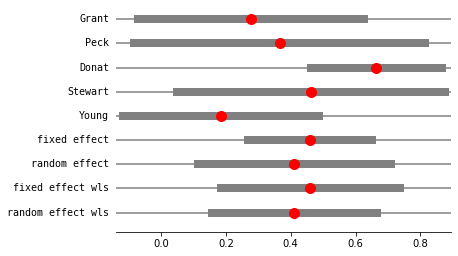

In [95]:
fig = res1.plot_forest()

Similarly, another example with the effect being the mean of measurements.

In [96]:
eff2 = np.array([61.00, 61.40, 62.21, 62.30, 62.34, 62.60, 62.70, 62.84, 65.90])
var_eff2 = np.array(
    [0.2025, 1.2100, 0.0900, 0.2025, 0.3844, 0.5625, 0.0676, 0.0225, 1.8225]
)
rownames2 = ["PTB", "NMi", "NIMC", "KRISS", "LGC", "NRC", "IRMM", "NIST", "LNE"]

method RE: dl
                         eff    sd_eff     ci_low     ci_upp      w_fe  \
PTB                61.000000  0.450000  60.118016  61.881984  0.057436   
NMi                61.400000  1.100000  59.244040  63.555960  0.009612   
NIMC               62.210000  0.300000  61.622011  62.797989  0.129230   
KRISS              62.300000  0.450000  61.418016  63.181984  0.057436   
LGC                62.340000  0.620000  61.124822  63.555178  0.030257   
NRC                62.600000  0.750000  61.130027  64.069973  0.020677   
IRMM               62.700000  0.260000  62.190409  63.209591  0.172052   
NIST               62.840000  0.150000  62.546005  63.133995  0.516920   
LNE                65.900000  1.350000  63.254049  68.545951  0.006382   
fixed effect       62.583397  0.107846  62.334704  62.832090  1.000000   
random effect      62.390139  0.245750  61.823439  62.956838       NaN   
fixed effect wls   62.583397  0.189889  62.145512  63.021282  1.000000   
random effect wls  62.39

C:\Users\Sébastien\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\stats\meta_analysis.py:106: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


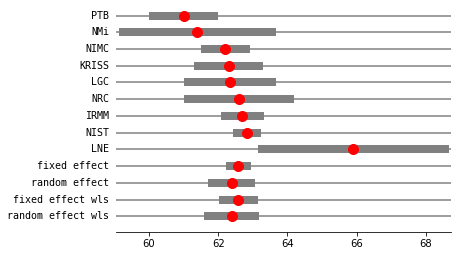

In [98]:
res2_DL = combine_effects(eff2, var_eff2, method_re="dl", use_t=True, row_names=rownames2)
print("method RE:", res2_DL.method_re)
print(res2_DL.summary_frame())
fig = res2_DL.plot_forest()

### Funnel plots

A funnel plot is a graph designed to check for the existence of publication bias; funnel plots are commonly used in systematic reviews and meta-analyses. In the absence of publication bias, it assumes that studies with high precision will be plotted near the average, and studies with low precision will be spread evenly on both sides of the average, creating a roughly funnel-shaped distribution. Deviation from this shape can indicate publication bias.

In [99]:
from funnelplot.core import funnel


## Meta-analysis of individual participant data (IPD meta-analysis)

A newer approach is for the meta-analysts to obtain the original data for each participant of each study, and reanalyze all the data together. This approach is considered the gold standard of meta-analysis and has determined definitive answers to clinical questions, which might not have been obtained from meta-analysis of summay data. This type of analysis ensures that the outcomes are defined in a consistent way, and that the data are analyzed using the same methods. Moreover, it can include more data than did the original paper because one get data at the root from the investigators, it can answer questions not posed by the original investigators, run subgroup analyses and account for confounding variables not considered by the original investigators.